In [2]:
from django.conf import settings
settings.configure(BASE_DIR='/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska/djangoapp',)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append('/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska') 

In [3]:
from djangoapp.news.scripts.llm import *
from djangoapp.news.scripts.model_loader import *
from djangoapp.news.scripts.nlp import *

In [4]:
import pandas as pd
import pickle  
from tqdm.notebook import tqdm 

df = pd.read_csv('../all_datasets/data/merged_titles_labels.csv')

In [5]:
df_test = df[df['sample'] == 'test'].reset_index(drop=True)
df_test

df_test_text = df_test[df_test['text'].notnull()].reset_index(drop=True)
df_test_no_text = df_test[df_test['text'].isnull()].reset_index(drop=True)

In [6]:
model_loader = ModelLoader()
llm = model_loader.llm 
vertex = model_loader.vertex
summarizer = model_loader.summarizer

## Testing Local LLM

In [7]:
datasets_llm = [df_test]
datasets_llm_names = ['df_test']

for dataset, dataset_name in zip(datasets_llm, datasets_llm_names):
    print(f'Predicting {dataset_name}...')
    for i, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        if row['title'] is not None:
            dataset.loc[i, 'llm_pred'] = llm.predict(row['title'])
        else:
            dataset.loc[i, 'llm_pred'] = None



Predicting df_test...


  0%|          | 0/2590 [00:00<?, ?it/s]

In [40]:


y_true = df_test['is_clickbait'].values
y_pred_proba = df_test['llm_pred'].values
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')



F1:          0.8193
ROC AUC:     0.9672
Recall:      0.7010
Precision:   0.9856
Accuracy:    0.8483


Text(50.722222222222214, 0.5, 'True')

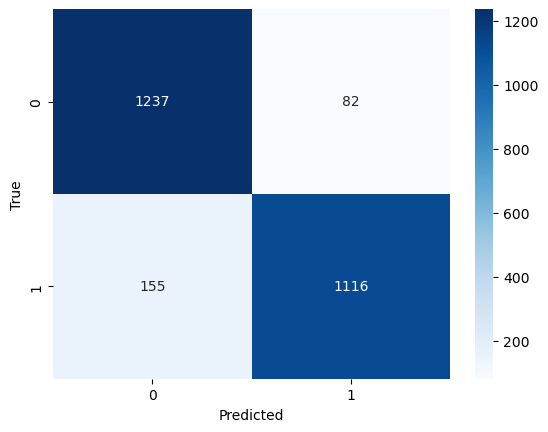

In [16]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
plt.xlabel('Predicted')
plt.ylabel('True')

In [9]:
# find optimal threshold for F1 score
n = 10000
thresholds = []
for i in tqdm(range(n)):
    threshold = i/n
    y_pred = (y_pred_proba > threshold).astype(int)
    thresholds.append((threshold, f1_score(y_true, y_pred)))
thresholds.sort(key=lambda x: x[1], reverse=True)
thresholds[:1][0][0]

  0%|          | 0/10000 [00:00<?, ?it/s]

0.0043

In [46]:
y_true = df_test['is_clickbait'].values
y_pred_proba = df_test['llm_pred'].values
y_pred = (y_pred_proba > thresholds[:1][0][0]).astype(int)

from sklearn.metrics import roc_auc_score, f1_score
print(f'ROC AUC best F1 thresh: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'F1 best F1 thresh: {f1_score(y_true, y_pred):>15.4f}')
print(f'Recall best F1 thresh: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision best F1 thresh: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy best F1 thresh: {accuracy_score(y_true, y_pred):>9.4f}')




ROC AUC best F1 thresh:     0.9672
F1 best F1 thresh:          0.9040
Recall best F1 thresh:      0.8780
Precision best F1 thresh:   0.9316
Accuracy best F1 thresh:    0.9085


In [11]:
# save df
df_test.to_csv('llm_results.csv', index=False)